# Image and Video Processing: From Mars to Hollywood with a Stop at the Hospital
## Assignment 1

### Problem 1: 

Write  a computer program capable of reducing the number of intensity levels  in an image from 256 to 2, in integer powers of 2. The desired number of  intensity levels needs to be a variable input to your program.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#same sample images I took
pooley = cv2.imread('2025-01-14-0029.jpg', cv2.IMREAD_GRAYSCALE)
trash_can = cv2.cvtColor(cv2.imread('001366280025-2.jpg'), cv2.COLOR_BGR2RGB)
AGO = cv2.imread('0006-2.jpg', cv2.IMREAD_GRAYSCALE)

val = []
for i in range(9):
    val.append(2**i)

'''
This will be the function that does that I want.
image is the image we want to adjust, and 
n_levels is the number of intensity levels. 
If n_levels is not a power of 2 I will raise an error:
'''
def reduce_intensity(image, n_levels):
    if n_levels not in val:
        raise TypeError(f"{n_levels} is not in the list {val}")

    m = int(256/n_levels)
    reduced = np.floor(image/m)*m
  
    return reduced.astype(int)

Now we're going to see what happens to an image as we reduce the number of levels of intensity from 256 to 2.

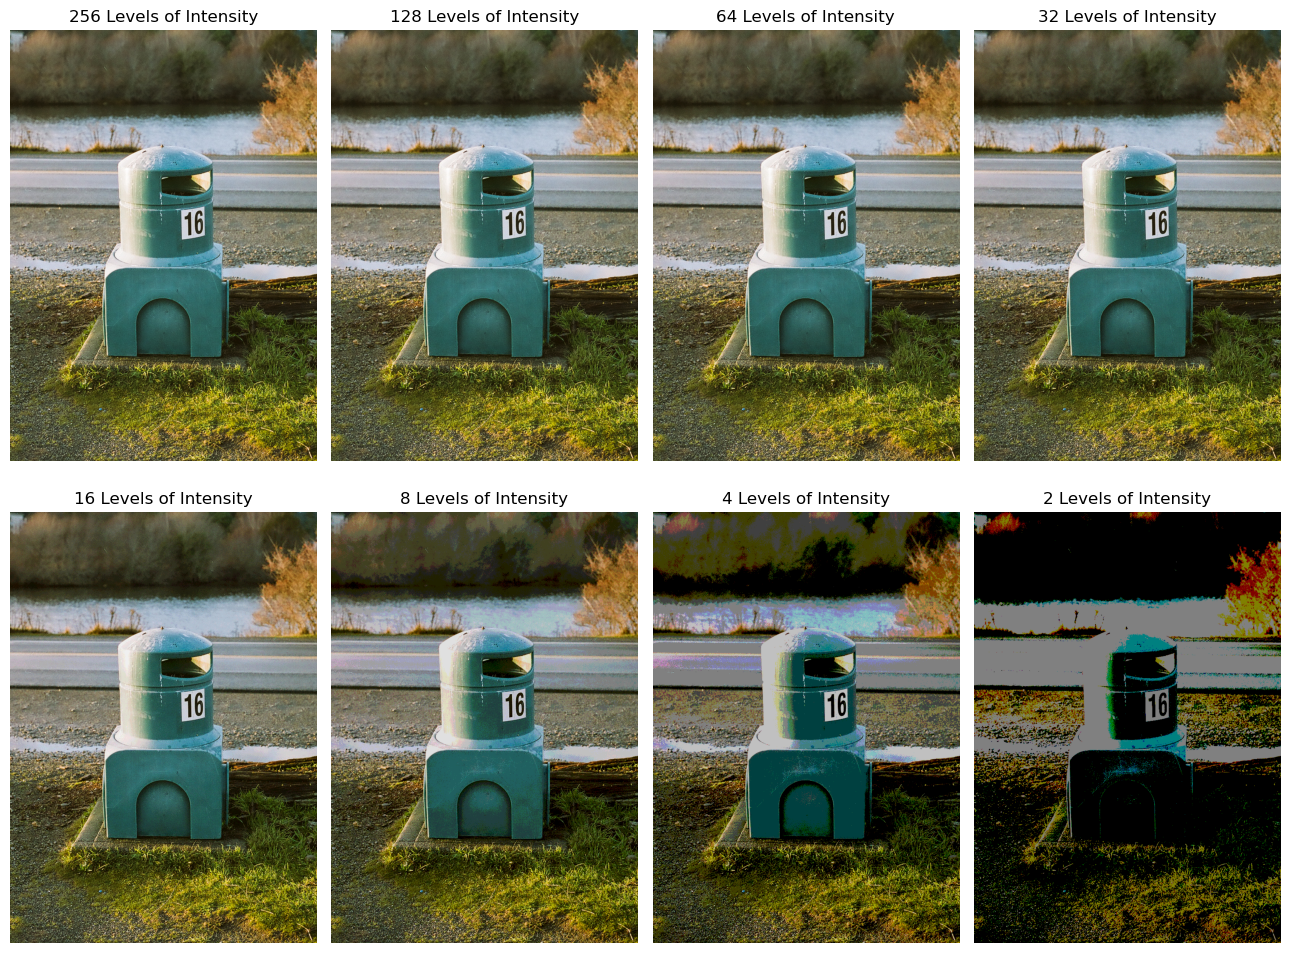

In [2]:
# now plot what happens as the number of intensity levels decreases
images = []
for i in range(8):
    images.append(reduce_intensity(trash_can, 2**(i+1)))

fig, axes = plt.subplots(2, 4, figsize=(13, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[7-i])
    ax.set_title(f'{2**(8-i)} Levels of Intensity')
    ax.axis('off')  

plt.tight_layout()  
plt.show()

### Problem 2: 

Using  any programming language you feel comfortable with (it is though  recommended to use the provided free Matlab), load an image and then  perform a simple spatial 3x3 average of image pixels. In other words,  replace the value of every pixel by the average of the values in its 3x3  neighborhood. If the pixel is located at (0,0), this means averaging  the values of the pixels at the positions (-1,1), (0,1), (1,1), (-1,0),  (0,0), (1,0), (-1,-1), (0,-1), and (1,-1). Be careful with pixels at the  image boundaries. Generalize for any $n\times n$-neighbourhood. 

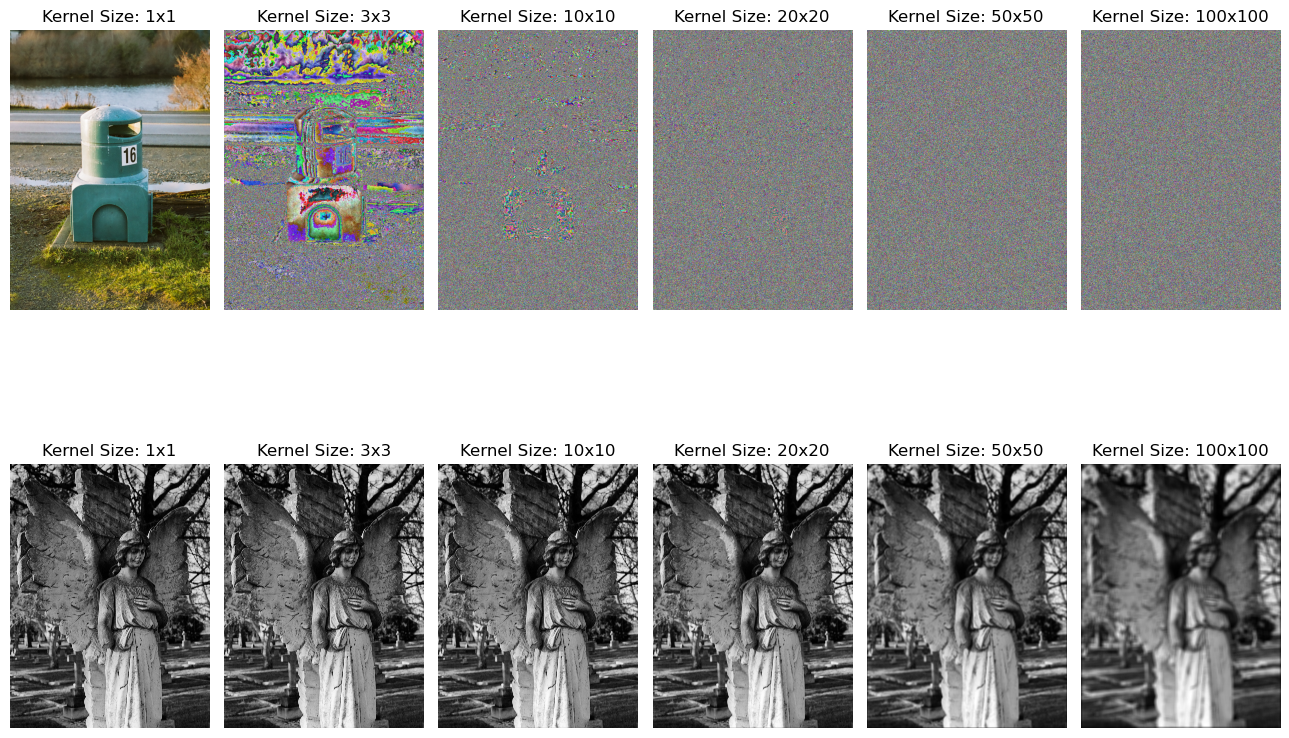

In [3]:
from scipy.signal import convolve2d

# going to use convolve2d from scipy for fast implementation
def pixel_avg(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size))
    if image.ndim not in [2,3]:
        raise TypeError('Please enter a black and white or colour image')
    elif image.ndim == 2:
        return convolve2d(image, kernel, mode='same', boundary='fill', fillvalue=0)
    elif image.ndim == 3:    
        temp = np.zeros_like(image)
        for i in range(3):
            temp[:,:,i] = convolve2d(image[:,:,i], kernel, mode='same', boundary='fill', fillvalue=0)
        return temp

# now get some sample values to see how this affects the image
k_sizes = [1, 3, 10, 20, 50, 100]
sampled_images = []

for size in k_sizes:
    sampled_images.append(pixel_avg(trash_can, size))

for size in k_sizes:
    sampled_images.append(pixel_avg(pooley, size))

fig, axes = plt.subplots(2, int(len(sampled_images)/2), figsize=(13, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(sampled_images[i], cmap = 'grey')
    ax.set_title(f'Kernel Size: {k_sizes[i%len(k_sizes)]}x{k_sizes[i%len(k_sizes)]}')
    ax.axis('off') 

plt.tight_layout()  
plt.show()

It is interesting to see the difference between how it affects colour images vs. black and white images! 

Some thoughts about this problem. Of course, this could be implemented using a for loop. However, a more computationally efficient method is to vectorize the code and use the computational optimization offered through NumPy. The algorith for this is as follows:

**Step 1:** Zero-pad (or however you want) your image in order to deal with the indices being out of bounds.

**Step 2:** Observe that the averaging operation is linear, and is therefore implemented by a matrix multiplication. Suppose that your kernel is of size $(2k+1)\times (2k+1)$ and your image is of size $m\times n$. Letting $E_{a,b}$ denote the standard basis matrices, the averaging transformation is given by 
$$ E_{a,b} \mapsto \left\{
    \begin{array}{ll}
        0 & \text{if } 0 \leq a,b < k,\text{ or } m+k < a,\text{ or } n+k < b\\
        \frac{1}{(2k+1)^2}\sum_{i,j = -k}^k E_{a+i, b+j} & \text{else}  
    \end{array}
\right. $$

**Step 3:** Write down the matrix implementing this transformation, and do the matrix multiplication. 

Presumably this is the SciPy implementation. 

### Problem 3: 

Rotate the image by 45 and 90 degrees (Matlab provides simple command lines for doing this).

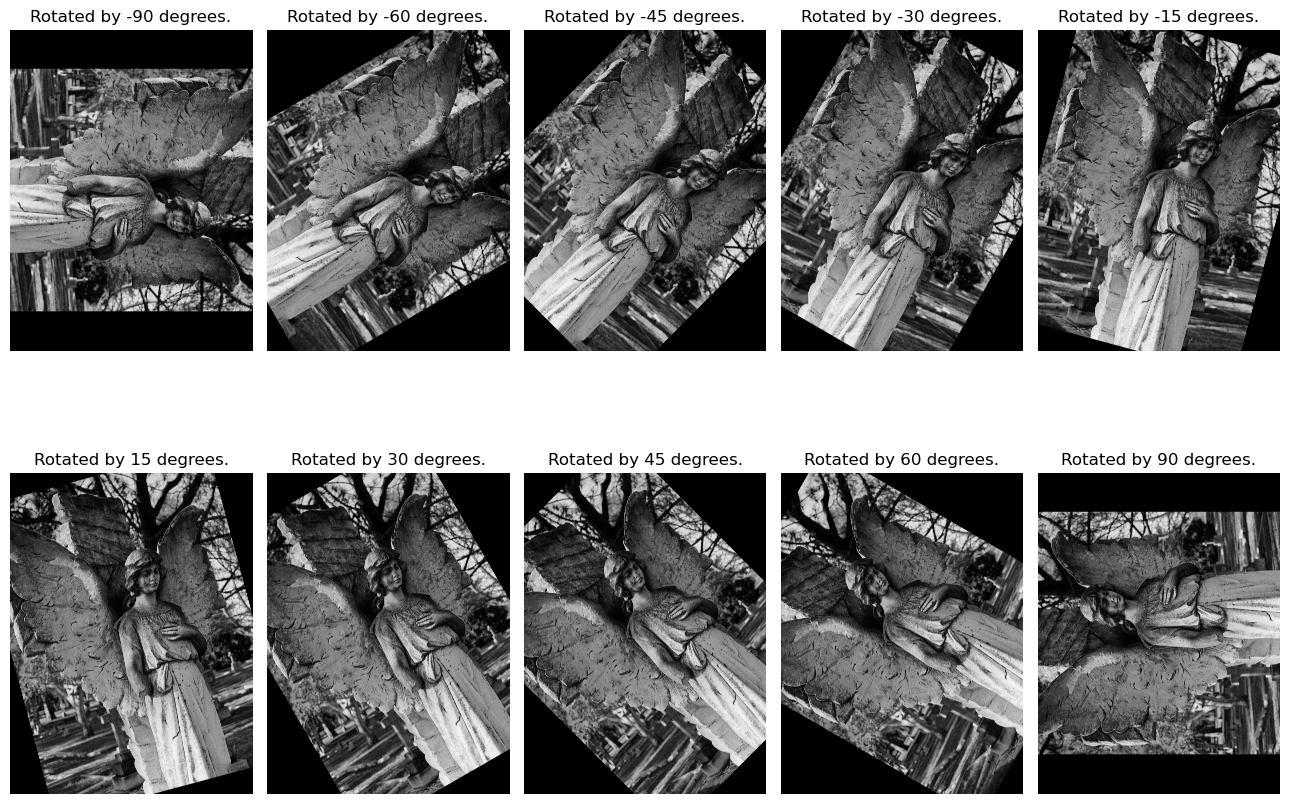

In [4]:
def rotate_img(image, d):
    '''
    Rotates image by d degrees
    '''
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, d, 1.0)

    return cv2.warpAffine(image, M, (w, h))

angles = [-90, -60,-45,-30, -15, 15, 30, 45, 60, 90]
rotated_images = []

for angle in angles:
    rotated_images.append(rotate_img(pooley, angle))

fig, axes = plt.subplots(2, int(len(rotated_images)/2), figsize=(13, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(rotated_images[i], cmap = 'grey')
    ax.set_title(f'Rotated by {angles[i]} degrees.')
    ax.axis('off') 

plt.tight_layout()  
plt.show()

### Problem 4: 

For  every 3×3 block of the image (without overlapping), replace  all corresponding 9 pixels by their average. This operation simulates  reducing the image spatial resolution. Repeat this for 5×5  blocks and 7×7 blocks. If you are using Matlab, investigate  simple command lines to do this important operation.

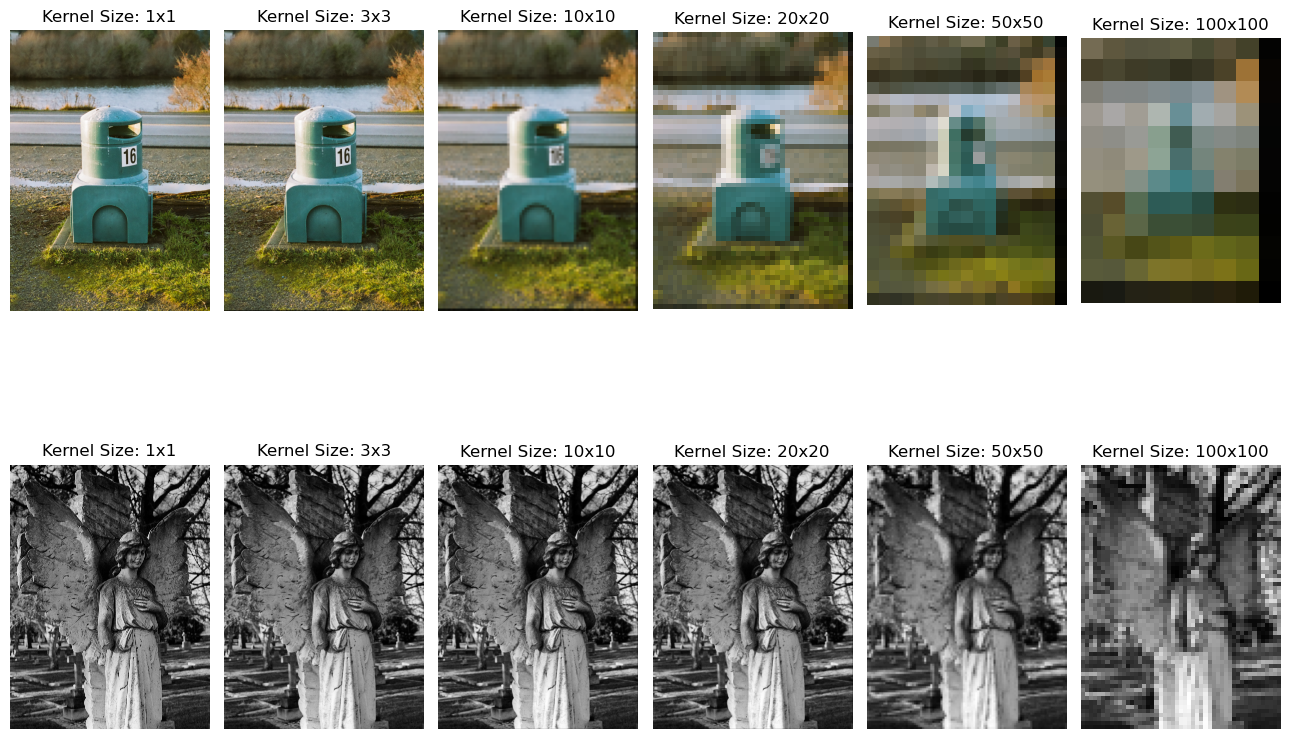

In [5]:
import numpy as np

def block_reshape(arr, nrows, ncols):
    '''
    Turns arr into a list of matrices of size (nrows, ncols)
    '''
    h, w = arr.shape
    # zero-pad the image if necessary
    pad_h = (nrows - h % nrows) % nrows
    pad_w = (ncols - w % ncols) % ncols
    arr = np.pad(arr, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    
    _h, _w = arr.shape
    # Reshape into blocks of (nrows, ncols)
    reshaped = arr.reshape(_h // nrows, nrows, _w // ncols, ncols)
    reshaped = reshaped.swapaxes(1, 2)  # Swap the block dimensions
    return reshaped.reshape(-1, nrows, ncols)  # Flatten the blocks into a list

# helper function to be applied to each channel of an image
def single_channel_pool(image, kernel_size):
    h, w = image.shape
    blocked_image = block_reshape(image, kernel_size, kernel_size)

    pooled = np.mean(blocked_image, axis = (1,2))
    return pooled.reshape(int(np.ceil(h/kernel_size)), int(np.ceil(w/kernel_size))).astype(int)

def mean_pool(image, kernel_size):
    if image.ndim not in [2,3]:
        raise TypeError('Please enter a black and white or colour image')
    elif image.ndim == 2:
        return single_channel_pool(image, kernel_size)
    elif image.ndim == 3:    
        h, w = image[:,:,0].shape
        temp = np.zeros((int(np.ceil(h/kernel_size)), int(np.ceil(w/kernel_size)),3))
        for i in range(3):
            temp[:,:,i] = single_channel_pool(image[:,:,i],kernel_size)
        return temp.astype(int)
    
# now get some sample values to see how this affects the image
k_sizes = [1, 3, 10, 20, 50, 100]
pooled_images = []

for size in k_sizes:
    pooled_images.append(mean_pool(trash_can, size))

for size in k_sizes:
    pooled_images.append(mean_pool(pooley, size))

fig, axes = plt.subplots(2, int(len(pooled_images)/2), figsize=(13, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(pooled_images[i], cmap = 'grey')
    ax.set_title(f'Kernel Size: {k_sizes[i%len(k_sizes)]}x{k_sizes[i%len(k_sizes)]}')
    ax.axis('off') 

plt.tight_layout()  
plt.show()
